In [1]:
### Download CelebA dataset
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
!unzip -qq celeba.zip

--2020-05-24 17:54:38--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.168
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  64.5MB/s    in 22s     

2020-05-24 17:55:01 (62.3 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [2]:
!ls img_align_celeba | wc -l

202599


In [0]:
import os
import math
import cv2
import matplotlib.pyplot as plt
import traceback
import numpy as np
from sklearn.model_selection import train_test_split

In [0]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda:0')

In [0]:
sample_im_path = 'img_align_celeba/000001.jpg'
im = cv2.imread(sample_im_path)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
im = cv2.resize(im,(128,128))

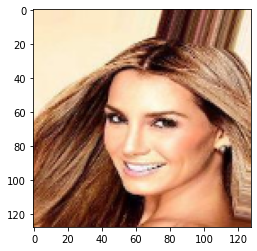

In [4]:
plt.imshow(im)

### Construct Dataset

In [0]:
main = 'img_align_celeba'
all_paths = []
for root,dir,files in os.walk(main):
  for f in files:
    all_paths.append(os.path.join(root,f))

### limit images to 5000
N = 5000
all_paths = all_paths[:N]

In [0]:
### split images to train and test
train, test = train_test_split(all_paths,test_size=0.2)

In [7]:
len(train), len(test)

(4000, 1000)

In [0]:
image_dim = (128,128)

vtrain = []
for f in train:
  try:
    im = cv2.imread(f)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = cv2.resize(im,image_dim)
    ### given an image of S x S x C, reshape it to S^2 x C, where C equals 3 channels
    vtrain.append(im.reshape(image_dim[0]**2,3).tolist())
  except:
    print(f)
    print(traceback.format_exc())
    pass

In [0]:
vtrain = np.array(vtrain)

In [0]:
vtest = []
for f in test:
  try:
    im = cv2.imread(f)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = cv2.resize(im,image_dim)
    ### given an image of S x S x C, reshape it to S^2 x C, where C equals 3 channels
    vtest.append(im.reshape(image_dim[0]**2,3).tolist())
  except:
    print(f)
    print(traceback.format_exc())
    pass

In [0]:
vtest = np.array(vtest)

In [0]:
from random import seed
from random import randint

seed(1)

In [0]:
random_index = randint(0, 100)

In [0]:
np.random(0,100)

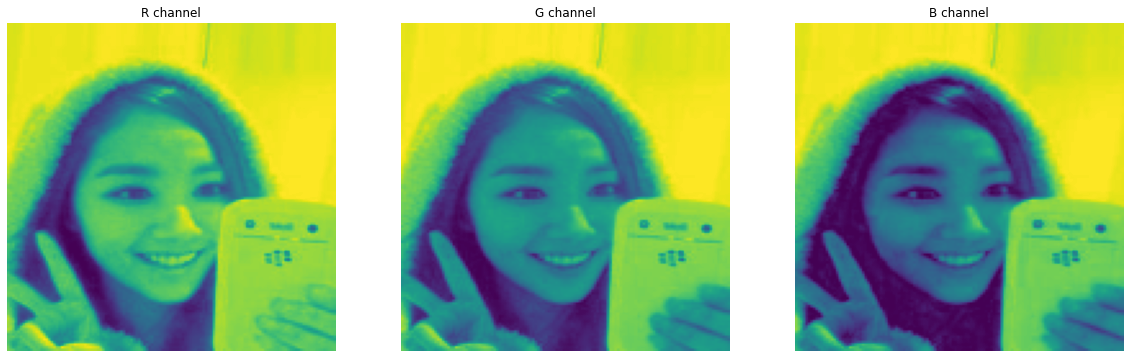

In [16]:
# R G B channels
rgb_chan = {
    0: 'R channel',
    1: 'G channel',
    2: 'B channel'
}
plt.figure(figsize=(20,10))
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.imshow(vtrain[random_index].reshape(128,128,3)[:,:,i])
  plt.title(rgb_chan[i])
  plt.axis('off')

### PCA for Image Reconstruction

In [0]:
vtrain_tensor = torch.from_numpy(vtrain).type(torch.float32).to(device)
### calculate mean image for each channel
vtrain_mean = vtrain_tensor.mean(dim=0,keepdim=True)
### center images' mean to zero
vtrain_centered = vtrain_tensor - vtrain_mean

In [19]:
vtrain_centered.shape, vtrain_tensor.shape, vtrain_mean.shape

(torch.Size([4000, 16384, 3]),
 torch.Size([4000, 16384, 3]),
 torch.Size([1, 16384, 3]))

Theoritically, PCA algorithm computes certain amount of principal axes, represented by eigenvectors, then the data matrix is projected into the principal axes, producing some principal components. 

In image reconstruction realm, the principal components are identical with eigenfaces, namely the projected image vectors with respect to the principal axes. The following function presents the necessary steps to produce eigenfaces given a collection of mean-centered images.

In [0]:
"""
  desc:
    Retrieve principal axes using SVD, then compute eigenfaces by projecting the images to the principal axes
    Eigenfaces are identical with principal components of the faces
  input:
    mean-centered image tensor, N x S^2
  output:
    eigenfaces, N x S^2
"""
def compute_eigenfaces(centered):

  ### given N x S^2 image vectors, 
  ### compute the covariance matrix of size N x N instead of S^2 x S^2
  cov = torch.matmul(centered,centered.T)

  ### that way, the svd computation will be more efficient
  ### this method will result in only N principal axes, however they still suffice to represent the images
  U,sigma,V = torch.svd(cov)

  ### project the data to the principal axes
  eigenfaces = torch.matmul(V.T,centered)

  ### normalize as unit vectors
  eigenfaces = (eigenfaces/torch.norm(eigenfaces,dim=1).unsqueeze(1))

  return eigenfaces

In [0]:
### Compute eigenfaces for each channel
r_eigenfaces, g_eigenfaces, b_eigenfaces = compute_eigenfaces(vtrain_centered[:,:,0]), compute_eigenfaces(vtrain_centered[:,:,1]), compute_eigenfaces(vtrain_centered[:,:,2])

In [0]:
eigenfaces = {
    0: r_eigenfaces,
    1: g_eigenfaces,
    2: b_eigenfaces
}

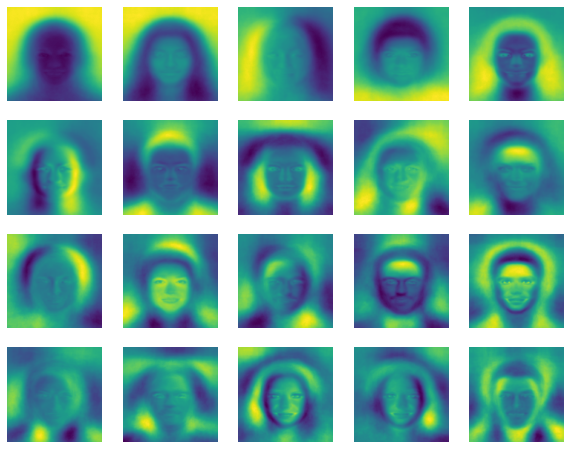

In [25]:
### Visualize eigenfaces
plt.figure(figsize=(10,8))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(eigenfaces[0][i].reshape(128,128).detach().cpu().numpy())
  plt.axis('off')

#### Reconstruct 1-channel Image

In [0]:
sample_centered_image = vtrain_centered[random_index,:,0].reshape(1,128*128)

In [0]:
### The sample image will be able to be represented by the linear combination of N eigenfaces
y = torch.matmul(sample_centered_image, eigenfaces[0].T)
recon = torch.matmul(y,eigenfaces[0]) + vtrain_mean[:,:,0]

(-0.5, 127.5, 127.5, -0.5)

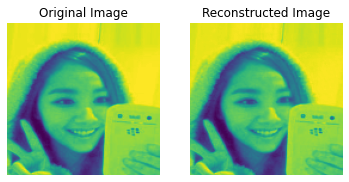

In [28]:
plt.subplot(1,2,1)
plt.imshow(vtrain_tensor[random_index,:,0].reshape(128,128).detach().cpu().numpy())
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(recon.reshape(128,128).detach().cpu().numpy())
plt.title('Reconstructed Image')
plt.axis('off')


The reconstructed result looks identical to the original image despite only N eigenfaces were utilized, instead of S^2 eigenfaces

N could still be reduced by referring at the top K singular values (sigma) that represent the variance of each principal axis

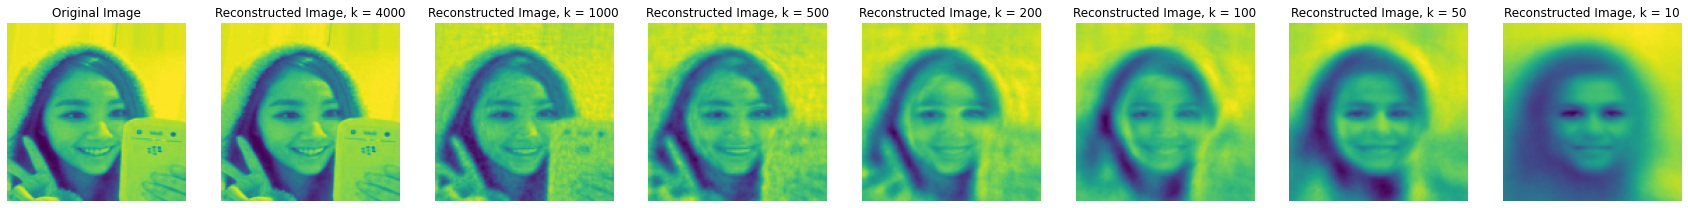

In [39]:
### Try to reconstruct the image with various number K eigenfaces

k_list = [4000,1000,500,200,100,50,10]
plt.figure(figsize=(30,5))
plt.subplot(1,len(k_list)+1,1)
plt.imshow(vtrain_tensor[random_index,:,0].reshape(128,128).detach().cpu().numpy())
plt.title('Original Image')
plt.axis('off')

for ix,k in enumerate(k_list):

  ### use top k eigenfaces
  y = torch.matmul(sample_centered_image, eigenfaces[0][:k].T)
  recon = torch.matmul(y,eigenfaces[0][:k]) + vtrain_mean[:,:,0]

  plt.subplot(1,len(k_list)+1,ix+2)
  plt.imshow(recon.reshape(128,128).detach().cpu().numpy())
  plt.title(f'Reconstructed Image, k = {k}')
  plt.axis('off')

In this case when k = 500, the reconstruction quality still looks tolerable

#### Reconstruct RGB images

In [0]:
### In order to reconstruct the whole image channels, 
rgb_recon = []
for i in range(3):

  ### reconstruct image for each channel
  sample = vtrain_centered[random_index,:,i].reshape(1,128*128)
  y = torch.matmul(sample, eigenfaces[i].T)
  _recon = torch.matmul(y,eigenfaces[i]) + vtrain_mean[:,:,i]

  ### clamp the reconstructed results between 0 and 255
  rgb_recon.append(_recon.reshape(128,128).clamp(0,255).unsqueeze(2))

### Form the RGB image
rgb = torch.cat((rgb_recon[0],rgb_recon[1],rgb_recon[2]),dim=2)

(-0.5, 127.5, 127.5, -0.5)

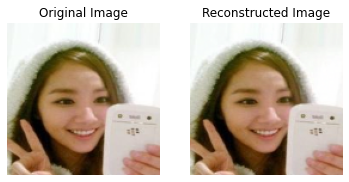

In [32]:
plt.subplot(1,2,1)
plt.imshow(vtrain_tensor[random_index,:,:].reshape(128,128,3).detach().cpu().numpy()/255)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(rgb.detach().cpu().numpy()/255)
plt.title('Reconstructed Image')
plt.axis('off')

### Again, the reconstructed image looks identical

### Image Inpainting using Recursive PCA

Image inpainting refers to a computer vision task where damaged or missing parts of an image are restored. The idea is, by projecting the damaged image to the retrieved principal axes iteratively, the missing regions can be filled in.

In [0]:
### Test dataset
vtest_tensor = torch.from_numpy(vtest).type(torch.float32).to(device)

In [0]:
### define mask
mask = torch.ones(128,128,3)
mask[60:70,40:60,:] = 0

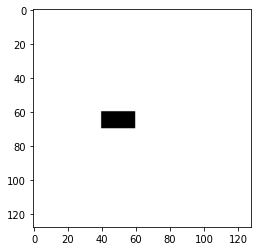

In [43]:
plt.imshow(mask)

Text(0.5, 1.0, 'Masked Image')

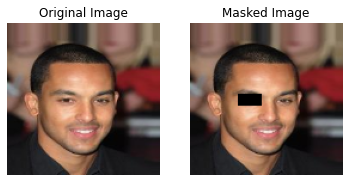

In [57]:
# Random test image index
test_index = randint(0,100)

plt.subplot(1,2,1)
plt.imshow(vtest_tensor[test_index,:,:].reshape(128,128,3)/255)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(vtest_tensor[test_index,:,:].reshape(128,128,3)*(mask)/255)
plt.axis('off')
plt.title('Masked Image')

Given a masked image, the goal of the recursive PCA algorithm is to fill in the missing region with appropriate pixels retrieved from the eigenface space. Since our image has 3 channels, the algorithm is applied for each channel and later, the reconstructed channels will be concatenated to form a complete RGB image.

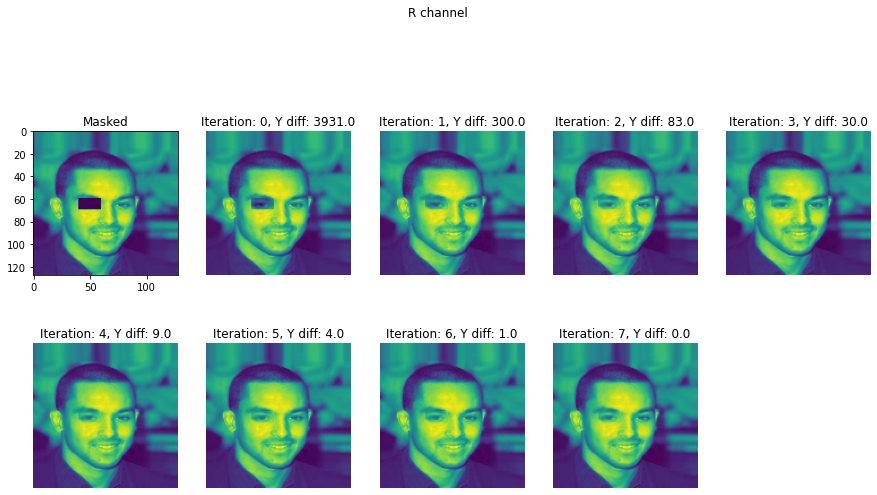

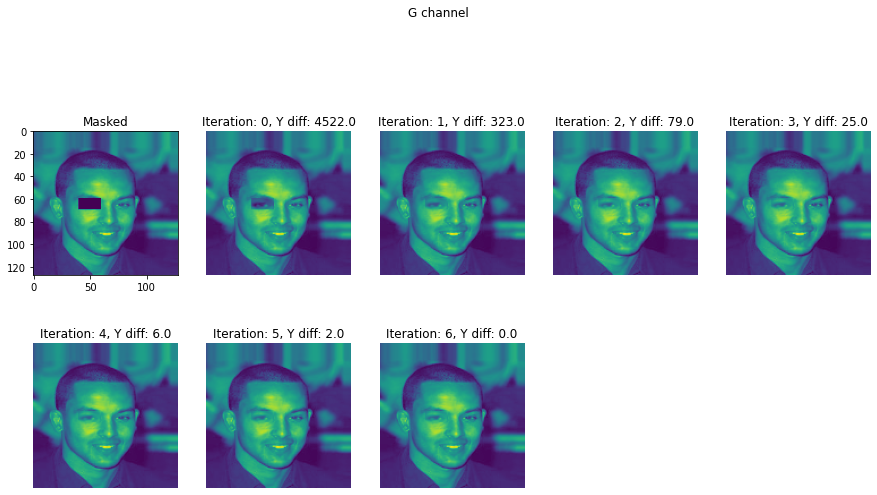

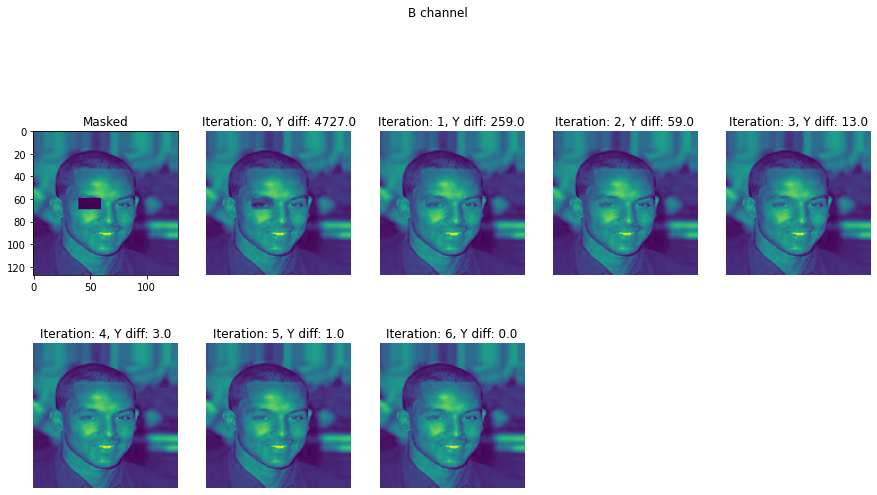

In [58]:
### Recursive PCA reconstructiion

num_iter = 20
col_per_row = 5
rows = math.ceil(num_iter / col_per_row)

### momentum rate
alpha = 0.5

rgb_recon = []

### top k eigenfaces
topk=150

### Loop for each channel
for c in range(3):
  masked = vtest_tensor[test_index,:,c].reshape(128,128)*(mask[:,:,0])
  recon = masked
  y_diff = 1e6

  plt.figure(figsize=(15,15))
  plt.suptitle(rgb_chan[c])
  y_prev = 1000

  plt.subplot(rows,col_per_row,1)
  plt.imshow(masked)
  plt.title('Masked')

  for i in range(num_iter-1):
    curr_row = math.floor(i/col_per_row) + 1
    plt.subplot(rows,col_per_row,i+2)

    ### get linear combination y of topk eigenfaces that best represent the masked image
    y = torch.matmul(recon.reshape(1,128**2) - vtrain_mean[:,:,c], eigenfaces[c][:topk].T)

    ### add momentum
    if y_diff != 1e6:
      y = y + alpha * (y - y_prev)

    ### get reconstructed image from eigenface space
    result = (torch.matmul(y,eigenfaces[c][:topk]) + vtrain_mean[:,:,c]).reshape(128,128)

    ### only pick up the reconstructed masked region and set the rest to groundtruth
    recon = (result * (1-mask[:,:,0])) + recon * (mask[:,:,0])
    
    ### get maximum coef difference
    y_diff = torch.round(torch.max(torch.abs(y_prev - y))).item()
    
    plt.title('Iteration: {}, Y diff: {}'.format(i,y_diff))
    plt.imshow(recon)
    plt.axis('off')
    
    y_prev = y

    ### stops iteration when the y difference has converged
    if y_diff < 0.05:
      break

  ### append reconstructed image channel
  rgb_recon.append(recon)

In [0]:
### Concatenate channels
rgb_test = torch.cat((rgb_recon[0].unsqueeze(2),rgb_recon[1].unsqueeze(2),rgb_recon[2].unsqueeze(2)),dim=2)

Text(0.5, 1.0, 'Reconstructed Image')

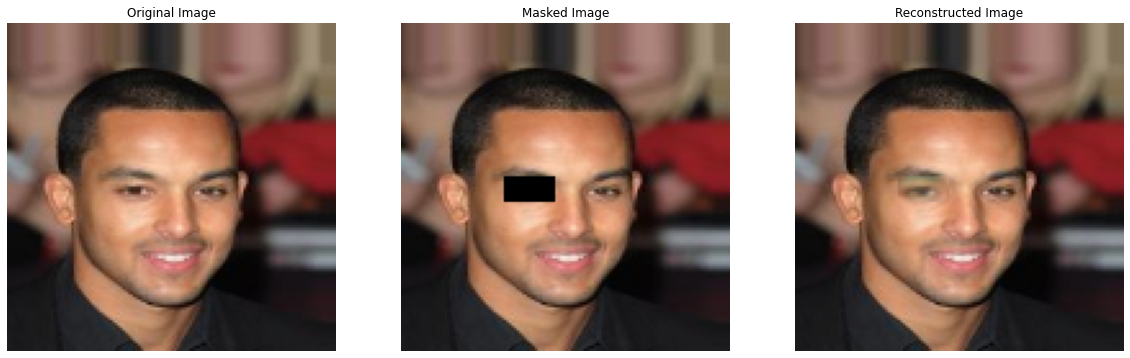

In [60]:
### Visualize results
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(vtest_tensor[test_index,:,:].reshape(128,128,3)/255)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(vtest_tensor[test_index,:,:].reshape(128,128,3)*(mask)/255)
plt.axis('off')
plt.title('Masked Image')

plt.subplot(1,3,3)
plt.imshow(rgb_test/255)
plt.axis('off')
plt.title('Reconstructed Image')

In [0]:
### FIN